In [2]:
! pip install matplotlib
! pip install numpy
! pip install torch
! pip install pandas
! pip install opencv-python

     |████████████████████████████████| 7.3 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 18.1 MB 529 kB/s eta 0:00:01
     |████████████████████████████████| 240 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 1.1 MB/s eta 0:00:01
  Using cached torch-1.13.0-cp39-none-macosx_10_9_x86_64.whl (137.9 MB)
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Using cached pandas-1.5.2-cp39-cp39-macosx_10_9_x86_64.whl (12.1 MB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-macosx_10_15_x86_64.whl (46.4 MB)


In [4]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.nn import Sequential as seq
from torch.nn import Conv1d as c1d
from torch.nn import Linear as l_n
from torch.nn import ReLU as rel
from torch.nn import Dropout as drop
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.functional import nll_loss as nll_loss
from torch.autograd import Variable
import cv2

In [5]:
class CharacterConvolutionNetwork(nn.Module):                                       # Class for Character Convolution Network (CCN) 
    def __init__(self, n_classes=4, input_length=1014, input_dim=68):
        self.ker_siz=[7,7,3,3,3,3]
        super(CharacterConvolutionNetwork, self).__init__()
        self.conv1 = seq(c1d(input_dim, 256, kernel_size=self.ker_siz[0]), rel(),
                                   nn.MaxPool1d(3))
        self.conv2 = seq(c1d(256, 256, kernel_size=self.ker_siz[1], padding=0), rel(),
                                   nn.MaxPool1d(3))
        self.conv3 = seq(c1d(256, 256, kernel_size=self.ker_siz[2], padding=0), rel())
        self.conv4 = seq(c1d(256, 256, kernel_size=self.ker_siz[3], padding=0), rel())
        self.conv5 = seq(c1d(256, 256, kernel_size=self.ker_siz[4], padding=0), rel())
        self.conv6 = seq(c1d(256, 256, kernel_size=self.ker_siz[5], padding=0), rel(),
                                   nn.MaxPool1d(3))

        dimension = int((input_length - 96) / 27 * 256)
        self.fc1 = seq(l_n(dimension, 1024), drop(0.5))
        self.fc2 = seq(l_n(1024, 1024), drop(0.5))
        self.fc3 = l_n(1024, n_classes)
        mn = 0.0
        std_dev = 0.05
        self._weights(mean=mn, std=std_dev)

    def _weights(self, mean=0, std=0.05):
        for module in self.modules():
            if isinstance(module, c1d) or isinstance(module, l_n):
                module.weight.data.normal_(mean, std)

    def forward(self, inp):
        inp = inp.transpose(1, 2)
        y = self.conv1(inp)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.conv4(y)
        y = self.conv5(y)
        y = self.conv6(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)
        return y

In [6]:
characterConvolutionNetwork = CharacterConvolutionNetwork(4)
print(characterConvolutionNetwork)

CharacterConvolutionNetwork(
  (conv1): Sequential(
    (0): Conv1d(68, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8704, out_features=1024, bias=True)
    (1): Dropout(p=0.5, inplace=Fal

In [7]:
data=pd.read_csv(r'./dataset/train.csv')
train_df=pd.DataFrame(data,columns=["class","title","desc"])
print(train_df)

        class                                              title  \
0           3  Wall St. Bears Claw Back Into the Black (Reuters)   
1           3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2           3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3           3  Iraq Halts Oil Exports from Main Southern Pipe...   
4           3  Oil prices soar to all-time record, posing new...   
...       ...                                                ...   
119995      1  Pakistan's Musharraf Says Won't Quit as Army C...   
119996      2                  Renteria signing a top-shelf deal   
119997      2                    Saban not going to Dolphins yet   
119998      2                                  Today's NFL games   
119999      2                       Nets get Carter from Raptors   

                                                     desc  
0       Reuters - Short-sellers, Wall Street's dwindli...  
1       Reuters - Private investment firm Carlyle Grou...  
2  

In [8]:
data=pd.read_csv(r'./dataset/test.csv')
test_df=pd.DataFrame(data,columns=["class","title","desc"])
print(test_df)

      class                                              title  \
0         3                  Fears for T N pension after talks   
1         4  The Race is On: Second Private Team Sets Launc...   
2         4      Ky. Company Wins Grant to Study Peptides (AP)   
3         4      Prediction Unit Helps Forecast Wildfires (AP)   
4         4        Calif. Aims to Limit Farm-Related Smog (AP)   
...     ...                                                ...   
7595      1                                   Around the world   
7596      2                        Void is filled with Clement   
7597      2                             Martinez leaves bitter   
7598      3  5 of arthritis patients in Singapore take Bext...   
7599      3                             EBay gets into rentals   

                                                   desc  
0     Unions representing workers at Turner   Newall...  
1     SPACE.com - TORONTO, Canada -- A second\team o...  
2     AP - A company founded by a

In [9]:
class TextDataset(Dataset):
    def __init__(self,df, max_length=1014):
#         self.data_path = data_path
        strr="""abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"""
        self.vocabulary = list(strr)

        self.identity_mat = np.identity(len(self.vocabulary))
        texts, labels = [], []
        
        self.labels = [int(i)-1 for i in df['class'].values]
        self.num_classes = len(set(self.labels))
        self.length = len(self.labels)
        self.texts = df['desc'].values
        self.max_length = max_length


    def __getitem__(self, index):
        raw_text = self.texts[index]
        isi_text = self.texts[index]
        vocabb= self.vocabulary
        data = np.array([self.identity_mat[self.vocabulary.index(i)] for i in list(raw_text) if i in vocabb], dtype=np.float32)

        if len(data) == 0:
            data = np.zeros((self.max_length, len(self.vocabulary)), dtype=np.float32)
        
        
        elif self.max_length > len(data) > 0 :
            data = np.concatenate((data, np.zeros((-(len(data) - self.max_length), len(self.vocabulary)), dtype=np.float32)))
        
        elif  self.max_length < len(data):
            data = data[:self.max_length]
        
        label = self.labels[index]
        
        return data, label

    def __len__(self):
        return self.length
        

In [10]:
trainset=TextDataset(train_df)

In [11]:
train_siz=int(0.9*120000)
valid_siz=120000-train_siz

In [12]:
trainloader = DataLoader(trainset, batch_size=128, num_workers=2, drop_last=True, shuffle=True)

In [13]:
optimizer = optim.SGD(characterConvolutionNetwork.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [14]:
epochs=8

In [15]:
class Config:
    def __init__(self):
        self.train=False
        self.model_dict_path='./model_dict.pth'

In [16]:
cnf=Config()

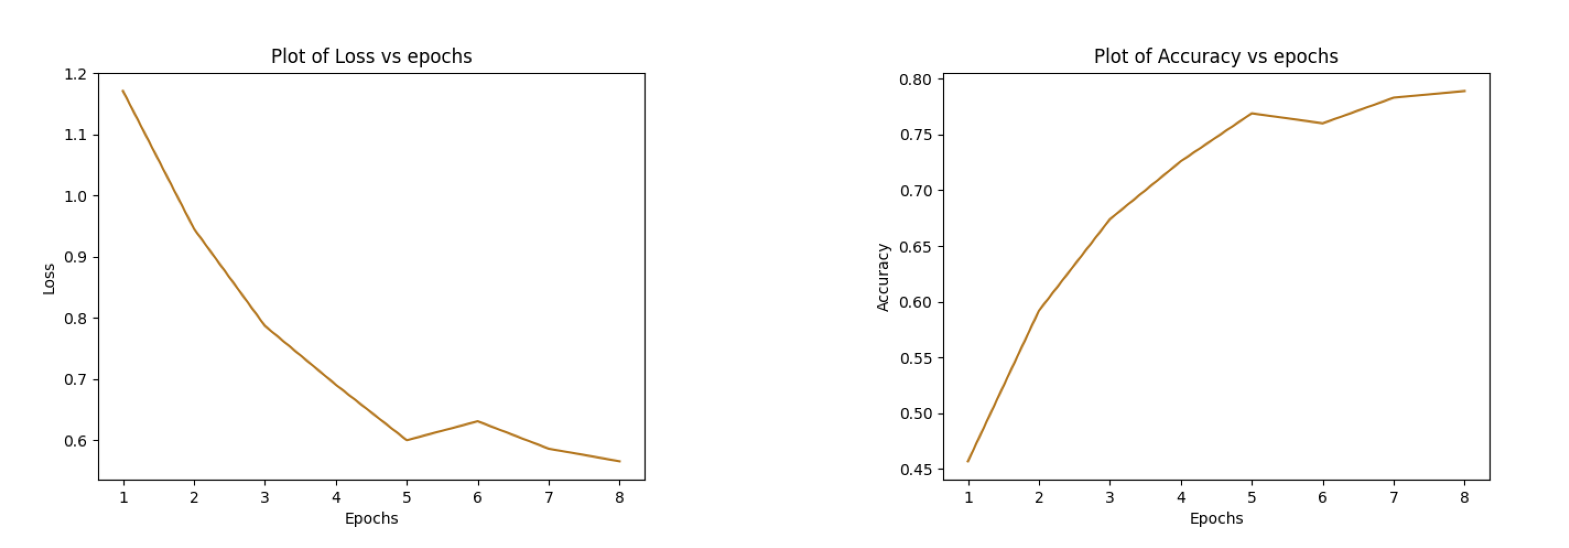

In [17]:
if cnf.train:
    for i in range(epochs):
        running_loss=0
        for j,data in enumerate(trainloader,0):
            x,y=data
            x=Variable(x)
            y=Variable(y)
            optimizer.zero_grad()
            out=characterConvolutionNetwork(x)
            loss=nll_loss(out,y)
            loss.backward()
            optimizer.step()
            if j%100==0:
                print(loss.data)
else:
    plt1=cv2.imread('./plot1.png')
    plt2=cv2.imread('./plot2.png')

    fig=plt.figure(figsize=(20,12))
    r=1
    c=2
    fig.add_subplot(r,c,1)
    plt.imshow(plt1,cmap='gray')
    plt.axis('off')
    fig.add_subplot(r,c,2)
    plt.imshow(plt2,cmap='gray')
    plt.axis('off')

In [18]:
if cnf.train:
    torch.save(characterConvolutionNetwork.state_dict(), cnf.model_dict_path)

In [19]:
model = CharacterConvolutionNetwork(4)
model.load_state_dict(torch.load('./model_dict.pth'))
model.eval()

CharacterConvolutionNetwork(
  (conv1): Sequential(
    (0): Conv1d(68, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8704, out_features=1024, bias=True)
    (1): Dropout(p=0.5, inplace=Fal